<a href="https://colab.research.google.com/github/kolmar7/rdf/blob/main/RDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Radial distribution function

Maria Kolonsky 2025

v.0.1.0

In [168]:
#! pip install shapely
from urllib.request import urlopen
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from shapely.geometry import Polygon, Point
import matplotlib.tri as mtri

## Parse XML datafile for $(x, y)$ points

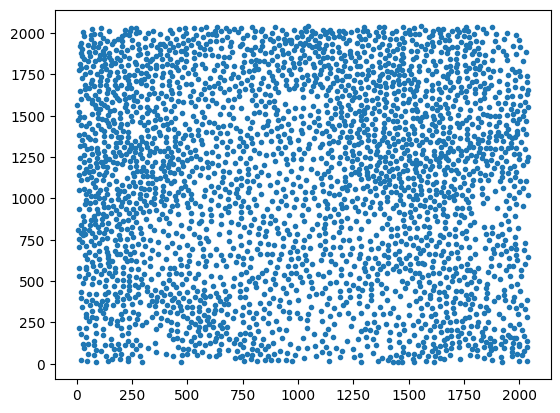

In [169]:
url = 'https://raw.githubusercontent.com/kolmar7/rdf/refs/heads/main/HaCaT%40pla-gel-CPNW%40PMMA(11x11%2Cx20)_2022-05-30_CellCounter_tile_x001_y002%20(1).xml'

#парсинг XML
def parsing_xml(xml_path: str, marker_type: int = 1):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    xc, yc = [], []
    for mtype in root.findall(".//Marker_Type"):
        t = mtype.findtext("Type")
        if not t or int(t.strip()) != marker_type:
            continue
        for m in mtype.findall(".//Marker"):
            x = m.findtext("MarkerX")
            y = m.findtext("MarkerY")
            if x and y:
                xc.append(int(x)); yc.append(int(y))
    return np.asarray(xc, dtype=np.int64), np.asarray(yc, dtype=np.int64)


#запуск
resp = urlopen(url, timeout=30)
X, Y = parsing_xml(resp, marker_type=1)

W = int(X.max()) + 1
H = int(Y.max()) + 1

# total square
S = W * H

N =  X.size


plt.scatter(X, Y, marker='.')

## Using module `shapely` to calculate square of intersection of a ring and rectangle

In [170]:
# frame for all x, y points
FRAME = Polygon([(0,0), (W,0), (W,H), (0,H)])


def ring_rect_intersection_area(cx, cy, r, deltar, resolution=8):
    """
    cx, cy:  центр круга
    r:       радиус круга
    deltar: приращение радиуса круга
    resolution: number of segments for quarter of circle
    """
    def circle_rect_intersection_area(cx, cy, r, resolution):
      circle = Point(cx, cy).buffer(r, resolution=resolution)  # resolution ↑ => точнее аппроксимация
      return FRAME.intersection(circle).area


    s0 = circle_rect_intersection_area(cx, cy, r, resolution)
    s1 = circle_rect_intersection_area(cx, cy, r + deltar, resolution)
    return s1 - s0

# пример
print(ring_rect_intersection_area(cx=1000, cy=1000, r=20, deltar=2, resolution=8))


262.2013927896801


## Using module `numpy` to calculate number of points inside the ring

In [172]:
def count_points(cx, cy, r, deltar):
  distance2 = (X - cx)**2 + (Y - cy)**2
  mask = (distance2 >= r**2) & ((distance2 <= (r+deltar)**2))
  count = np.count_nonzero(mask)
  return count

## Find density as number of points to square of intersection

In [173]:
def density(cx, cy, r, deltar):
  count  = count_points(cx, cy, r, deltar)
  relative_count = count / N
  square = ring_rect_intersection_area(cx, cy, r, deltar)
  relative_square = square / S
  if square == 0:
    rho = 0
  else:
    rho = relative_count / relative_square
  return rho

density = np.vectorize(density)



## Sweep for all possible radius averaged density




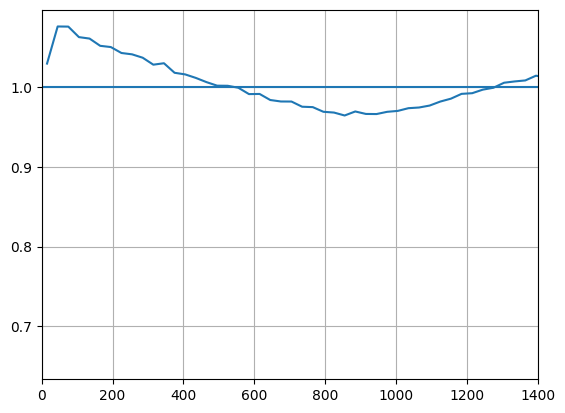

In [140]:
deltar = 30
r_max = min(W, H)

r_edges = np.arange(0, r_max+deltar, deltar, dtype=float)
R = 0.5 * (r_edges[:-1] + r_edges[1:])
g = np.zeros(R.size)

for i in range(N):
  x, y = X[i], Y[i]
  g += density(x, y, R, deltar )

g /= N
plt.plot(R, g)
plt.axhline(1)
plt.xlim(0, 1400)
plt.grid()

### The same for uniform distribution

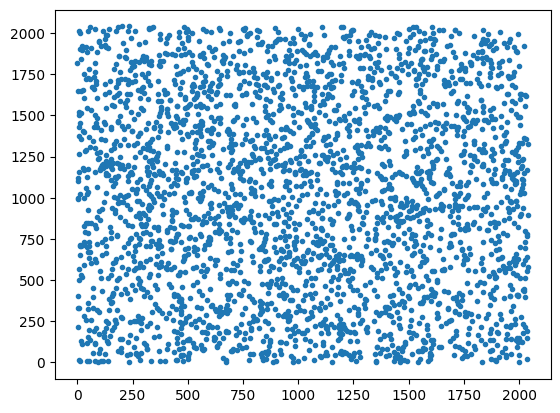

In [164]:
rng = np.random.default_rng(seed=123)
Xu = rng.uniform(0, W, size=N)
Yu = rng.uniform(0, H, size=N)
plt.scatter(Xu, Yu, marker='.')

In [142]:
deltar = 30
r_max = min(W, H)

r_edges = np.arange(0, r_max+deltar, deltar, dtype=float)
R = 0.5 * (r_edges[:-1] + r_edges[1:])
gu = np.zeros(R.size)

for i in range(N):
  x, y = Xu[i], Yu[i]
  gu += density(x, y, R, deltar )

gu /= N


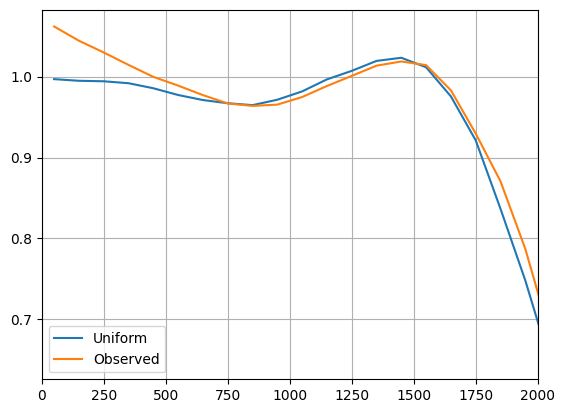

In [127]:
plt.plot(R, gu, label='Uniform')
plt.plot(R, g, label='Observed')
plt.legend()
plt.xlim(0, 2000)
plt.grid()

## test for a point in the center with growing radius

In [178]:
deltar = 10
R = np.arange(0, 2000, deltar)

xc, yc = W /2, H / 2



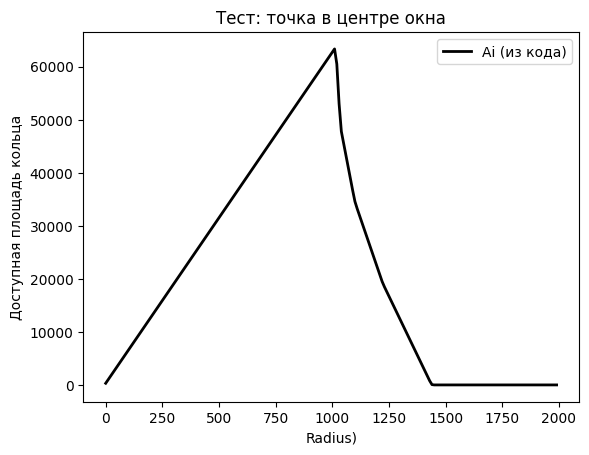

In [179]:
Ai = [ring_rect_intersection_area(xc, yc, r, deltar) for r in R]


# график
plt.plot(R, Ai, 'k-', lw=2, label="Ai (из кода)")
#plt.plot(R, Ai_theory, 'r--', lw=2, label="Ai (аналитика)")
plt.xlabel("Radius")
plt.ylabel("Доступная площадь кольца")
plt.title("Тест: точка в центре окна")
plt.legend()
plt.show()

In [159]:
N

1000